In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch.functional import F
from torchvision.transforms import v2
import os
from PIL import Image

In [2]:
train_dir = "data/train"
test_dir = "data/test"

to_tensor = v2.ToTensor()

mean = torch.zeros(1)
std = torch.zeros(1)
num_images = 0


for root in [train_dir,test_dir]:
    for subdir, _, files in os.walk(root):
        for file_name in files:
            if file_name.lower().endswith('.jpg'):
                img_path = os.path.join(subdir, file_name)
                try:
                    img = Image.open(img_path).convert('L')
                    tensor = to_tensor(img)  # [C, H, W]
                    mean += tensor.mean(dim=[1, 2])
                    std += tensor.std(dim=[1, 2])
                    num_images += 1
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")

if num_images == 0:
    raise ValueError("No image found")

mean /= num_images
std /= num_images

print(f"Mean: {mean}")
print(f"Std:  {std}")
print(f"Images number: {num_images}")

/home/vadimpp/.local/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Mean: tensor([0.5074])
Std:  tensor([0.2121])
Images number: 35887


In [3]:
from torch.utils.data import DataLoader, Dataset
import json

class FER_dataset(Dataset):
    def __init__(self, img_dir, train = True, transforms = None):
        self.img_dir = os.path.join(img_dir, "train" if train else "test")
        self.transforms = transforms

        with open(os.path.join(img_dir,"format.json"),"r") as fm:
            self.format = json.load(fm)

        self.length = 0
        self.files = []
        self.targets = torch.eye(len(self.format.keys()))

        for _dir, _target in self.format.items():
            path = os.path.join(self.img_dir,_dir)
            list_files = os.listdir(path)
            self.length += len(list_files)
            self.files.extend(map(lambda _x: (os.path.join(path,_x),_target), list_files))
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        path_file, target = self.files[idx]
        t = self.targets[target]
        img = Image.open(path_file)

        if self.transforms:
            img = self.transforms(img)
        
        return img, t

In [4]:

tfr = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean = mean, std = std)
])
id_to_cl = {}
with open(os.path.join("./data","format.json"),"r") as fm:
    id_to_cl = {idx:cl for cl,idx in json.load(fm).items()}

train_ds = FER_dataset(img_dir = "./data", train=True, transforms=tfr)
train_loader = DataLoader(train_ds,shuffle=True,batch_size=32)
test_ds = FER_dataset(img_dir = "./data", train=False, transforms=tfr)
test_loader = DataLoader(test_ds,shuffle=True,batch_size=32)

Dim of img: torch.Size([1, 48, 48])


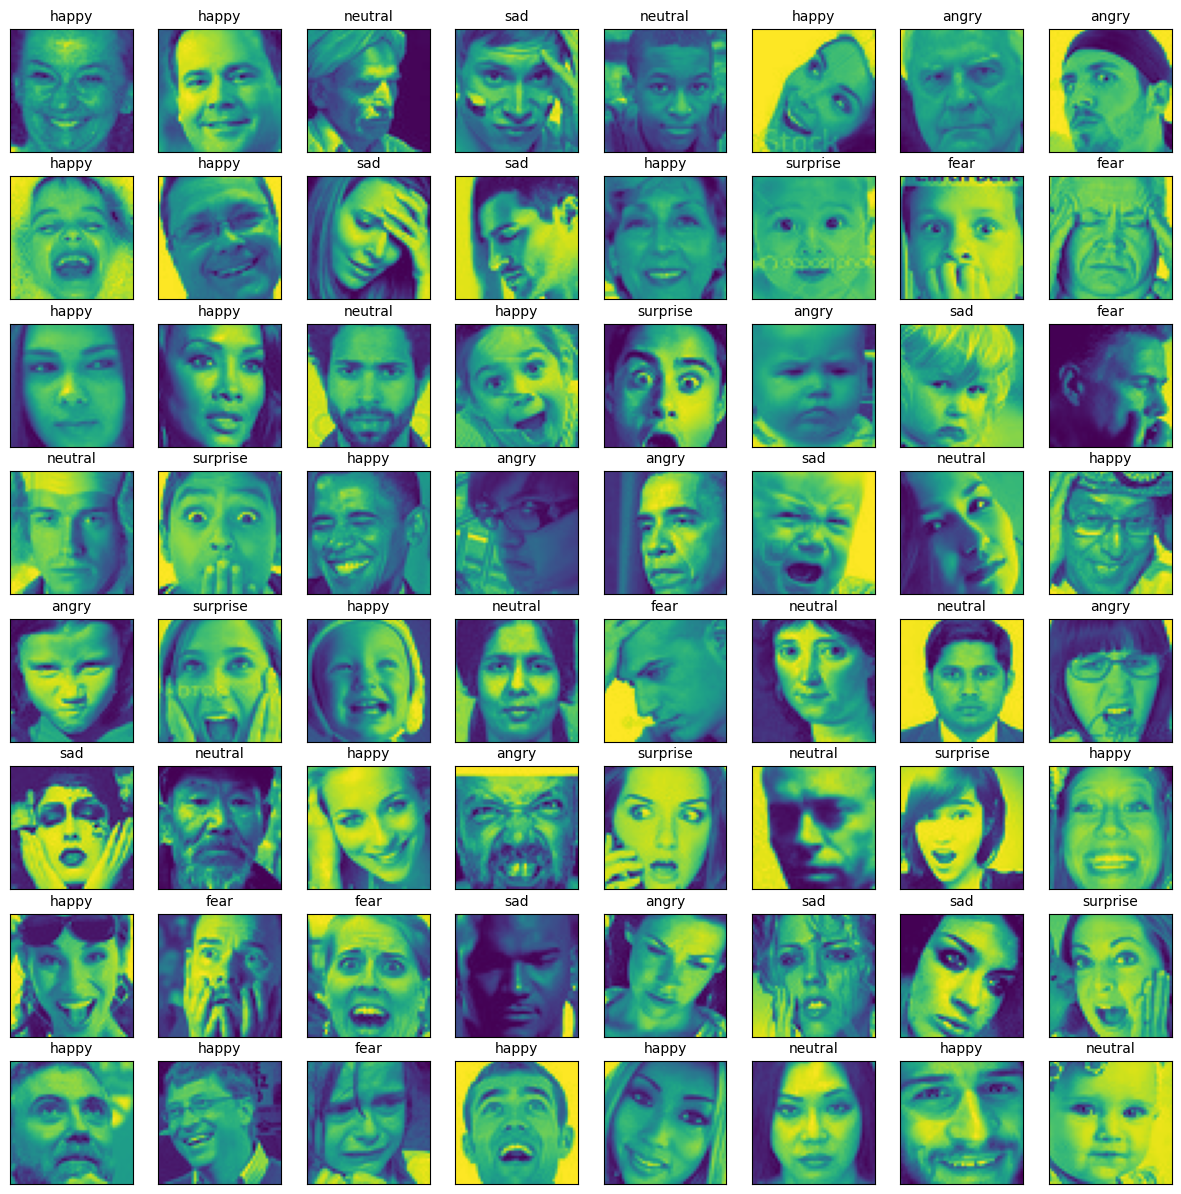

In [5]:
from random import randint

plt.figure(figsize = (15,15))

to_img = v2.ToPILImage()

for i in range(64):
    img, label = train_ds[randint(0,len(train_ds))]
    if i == 0: print("Dim of img:", img.shape)
    img = img.permute(1, 2, 0).numpy()
    img = img * std.numpy() + mean.numpy()              
    img = img.clip(0, 1)                
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(id_to_cl[torch.argmax(label).item()],fontsize = 10)

    plt.imshow(img)
plt.show()

In [6]:


class FER_model(torch.nn.Module):
    def __init__(self, num_classes=7):
        super(FER_model, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # channels_in=1 (Grayscale normalized)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.2)
        
        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.3)
        
        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.4)
        
        # Block 4
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(0.5)
        
        # full connected
        self.fc = nn.Linear(256 * 3 * 3, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.drop1(x)
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.drop2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.drop3(x)
        
        # Block 4
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.drop4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC
        x = self.fc(x)    
        return x

In [7]:
model = FER_model()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [9]:
epochs = 5
loss_epoch = []
acc_epoch = []
for ep in range(epochs):
    model.train()
    lm_count = 0
    loss_mean = 0.0 
    tqdm_loader = tqdm(train_loader, leave=True)
    for (x,y) in tqdm_loader:
        pred = model(x)
        loss = criterion(pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        tqdm_loader.set_description(f"Epoch [{ep+1}/{epochs}], loss_mean={loss_mean:.3f}")
    loss_epoch.append(loss_mean)
    Q = 0
    model.eval()
    tqdm_test_loader = tqdm(test_loader, leave=True)
    for x_test, y_test in tqdm_test_loader:
        with torch.no_grad():
            p = model(x_test)
            y_test = torch.argmax(y_test, dim=1)
            p = torch.argmax(p, dim=1)
            #print(p[0],y_test[0])
            Q += torch.sum(p == y_test).item()
        tqdm_test_loader.set_description(f"Epoch [{ep+1}/{epochs}] eval: Accuracy={Q/len(test_ds):.3f}")
    acc_epoch.append(Q/len(test_ds))

Epoch [4/5], loss_mean=1.003:   3%|▎           | 28/898 [00:04<02:09,  6.74it/s]


KeyboardInterrupt: 

In [ ]:
Q = 0

model.eval()

for x_test, y_test in test_loader:
    with torch.no_grad():
        p = model(x_test)
        y_test = torch.argmax(y_test, dim=1)
        p = torch.argmax(p, dim=1)
        #print(p[0],y_test[0])
        Q += torch.sum(p == y_test).item()
 
Q = Q/len(test_ds)
print(Q)


In [ ]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1,2,1)
plt.plot(loss_epoch, label='Train Loss', color='#8502d1')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1,2,2)
plt.plot(acc_epoch, label='Train Accuracy', color='green')
plt.legend()
plt.title('Accuracy Evolution')
